In [28]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import msgpack as mp
import msgpack_numpy as mpn
sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *
from support.ar_calculations import *
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
import keyboard
import time
from IPython.display import display, clear_output
import seaborn as sns


In [29]:
_parent_folder = "multi_cam_nov_14"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\Sujith\\Documents\\Projects\\armbo\\recording_programs\\test_data\\multi_cam_nov_14'

In [30]:
""" read excel sheet"""
folder_df = pd.read_excel(os.path.join(_base_pth, "00_analysis", "calibration_files_corrected.xlsx"))
_analysis_pth = os.path.join(_base_pth, "00_analysis")
folder_df

,folder_name,calibration_folder,flip
0,sk16_15_forward_fast,calibration_15fps_sk,False
1,sk16_15_forward_fast_2,calibration_15fps_sk,False
2,sk16_15_forward_medium,calibration_15fps_sk,False
3,sk16_15_forward_medium_2,calibration_15fps_sk,False
4,sk16_15_forward_slow,calibration_15fps_sk,False
...,...,...,...
84,sk16_60_sideways_fast_2,calibration_60fps_quad_sk_3,False
85,sk16_60_sideways_medium,calibration_60fps_quad_sk_3,False
86,sk16_60_sideways_medium_2,calibration_60fps_quad_sk_3,False
87,sk16_60_sideways_slow,calibration_60fps_quad_sk_3,False


In [31]:
def transform_coordinates_1(df, rotmat, org):
    df1 = df.copy( deep=True)
    for i in range(len(df)):
        val = df[["x", "y", "z"]].loc[i].values
        val = np.reshape(val, (3,1))
        _temp = val - org
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)
        _val = rotmat.T @ _temp
        _val = _val - translation_correction
        
        df1["x"].replace({df1["x"].loc[i]: _val[0]}, inplace=True)
        df1["y"].replace({df1["y"].loc[i]: _val[1]}, inplace=True)
        df1["z"].replace({df1["z"].loc[i]: _val[2]}, inplace=True)

    return df1

In [32]:
mean_err_df = pd.DataFrame(columns=["folder_name","date_created" ,"frame_id","err_x", "err_y", "err_z",
                                     "max_err_x", "max_err_y", "max_err_z",
                                     "std_err_x", "std_err_y", "std_err_z",
                                     "offset_x", "offset_y", "offset_z"])

In [33]:
for idx, _folder_name in enumerate(tqdm(folder_df.folder_name)):
    # print(idx)
    _phone_cam_folder = os.path.join(_analysis_pth, "coordinates_webcam_wot_2", _folder_name + ".csv")
    _mc_folder = os.path.join(_analysis_pth, "coordinates_mc_2", _folder_name + ".csv")

    _phone_cam_df = pd.read_csv(_phone_cam_folder)
    _mc_df = pd.read_csv(_mc_folder)

    #read the calibration file
    _webcam_calib_folder = folder_df.calibration_folder[idx]
    _webcam_calib_folder = os.path.join(_base_pth, _webcam_calib_folder)

    with open(os.path.join(_webcam_calib_folder, "webcam_rotmat.msgpack"), "rb") as f:
        webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
        _webcam_rot = next(webcam_rotmat)
        _webcam_org = next(webcam_rotmat)


    _w_df = transform_coordinates_1(_phone_cam_df, _webcam_rot, _webcam_org)
    _w_df.time = pd.to_datetime(_w_df.time)
    _mc_df.time = pd.to_datetime(_mc_df.time)

    # find the offset
    _offset_x = _w_df.x.iloc[0] - _mc_df.x.iloc[0]
    _offset_y = _w_df.y.iloc[0] - _mc_df.y.iloc[0]
    _offset_z = _w_df.z.iloc[0] - _mc_df.z.iloc[0]

    _mc_df.x = _mc_df.x + _offset_x
    _mc_df.y = _mc_df.y + _offset_y
    _mc_df.z = _mc_df.z + _offset_z


    # filter the data
    _w_df.x = savgol_filter(_w_df.x, 51, 1)
    _w_df.y = savgol_filter(_w_df.y, 51, 1)
    _w_df.z = savgol_filter(_w_df.z, 51, 1)
    
    error_df = pd.DataFrame()
    error_df["time"] = _mc_df["time"]
    error_df["x"] = _mc_df["x"] - _w_df["x"]
    error_df["y"] = _mc_df["y"] - _w_df["y"]
    error_df["z"] = _mc_df["z"] - _w_df["z"]
    error_df["frame_id"] = _w_df["frame_id"]

    mean_err_df = mean_err_df.append({"folder_name": folder_df.folder_name[idx],"date_created": None, "frame_id":  error_df["frame_id"][0],
                                    "err_x": error_df["x"].mean(), "err_y": error_df["y"].mean(), "err_z": error_df["z"].mean(), 
                                    "max_err_x": error_df["x"].max(), "max_err_y": error_df["y"].max(), "max_err_z": error_df["z"].max(), 
                                    "std_err_x": error_df["x"].std(), "std_err_y": error_df["y"].std(), "std_err_z": error_df["z"].std(),
                                    "offset_x": _offset_x, "offset_y": _offset_y, "offset_z": _offset_z}, ignore_index=True)

    

  1%|          | 1/89 [00:13<19:31, 13.32s/it]


KeyboardInterrupt: 

In [ ]:
# save the mean error
# _mean_df_pth = os.path.join(_analysis_pth, "mean_error_df_filter.csv")
# mean_err_df.to_csv(_mean_df_pth, index=False)

# read the mean error df
mean_err_df = pd.read_csv(os.path.join(_analysis_pth, "mean_error_df_filter.csv"))
mean_err_df

,folder_name,date_created,frame_id,err_x,err_y,err_z,max_err_x,max_err_y,max_err_z,std_err_x,std_err_y,std_err_z,offset_x,offset_y,offset_z
0,sk16_15_forward_fast,NaN,5.0,-0.003632,0.000328,0.000242,0.012087,0.013025,0.094254,0.006388,0.002433,0.028911,-0.004156,0.012670,-0.015501
1,sk16_15_forward_fast_2,NaN,5.0,-0.007081,-0.000291,-0.002699,0.001369,0.002615,0.042282,0.006281,0.000980,0.028473,-0.006541,0.012341,-0.015976
2,sk16_15_forward_medium,NaN,5.0,-0.005027,0.003032,0.014073,0.004393,0.007052,0.045433,0.005710,0.001099,0.017346,-0.004663,0.015651,0.001541
3,sk16_15_forward_medium_2,NaN,5.0,-0.007159,-0.001825,-0.014115,0.006083,0.002245,0.015662,0.006174,0.001144,0.016573,-0.007082,0.010688,-0.027590
4,sk16_15_forward_slow,NaN,5.0,-0.006739,0.001677,0.006852,0.002729,0.006113,0.035477,0.005866,0.001483,0.015245,-0.005457,0.014174,-0.008243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,sk16_60_sideways_fast_2,NaN,5.0,0.000790,0.003284,0.018577,0.043110,0.011391,0.051887,0.026745,0.003030,0.013943,0.002051,0.008722,-0.023042
85,sk16_60_sideways_medium,NaN,5.0,-0.002046,0.001053,0.004486,0.037510,0.013824,0.067163,0.022685,0.003275,0.014662,-0.005902,0.005281,-0.044543
86,sk16_60_sideways_medium_2,NaN,5.0,-0.000987,0.001586,0.007803,0.040251,0.008066,0.037752,0.022814,0.002542,0.011345,-0.000964,0.006815,-0.035289
87,sk16_60_sideways_slow,NaN,5.0,-0.007762,-0.001021,-0.007062,0.018429,0.004347,0.025648,0.013228,0.002217,0.010099,-0.008723,0.004387,-0.049639


In [ ]:
# find fps using filename
fps_values = []
for i in mean_err_df.folder_name:
    _fps = i.split("_")[1]
    _fps = int(_fps)
    fps_values.append(_fps)
mean_err_df["fps"] = fps_values

# find speed of movement
speed_values = []
for i in mean_err_df.folder_name:
    _speed = i.split("_")[3]
    speed_values.append(_speed)
mean_err_df["speed"] = speed_values

#object of movement
object_values = []
for i in mean_err_df.folder_name:
    _object = i.split("_")[2]
    
    if _object == "quad":
        object_values.append("quad")
    else:
        object_values.append("skateboard")
mean_err_df["object"] = object_values

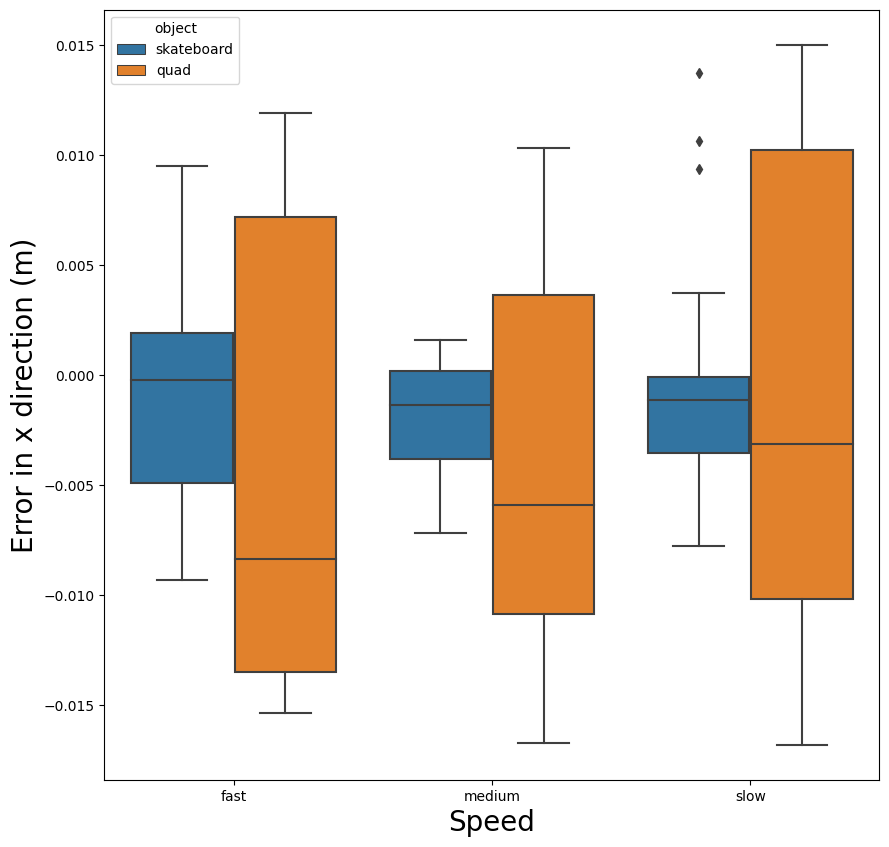

In [ ]:
# box plot based on speed
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x="speed", y="err_x", hue="object", data=mean_err_df, ax=ax)

# label
ax.set_xlabel("Speed", fontsize=20)
ax.set_ylabel("Error in x direction (m)", fontsize=20)
plt.show()

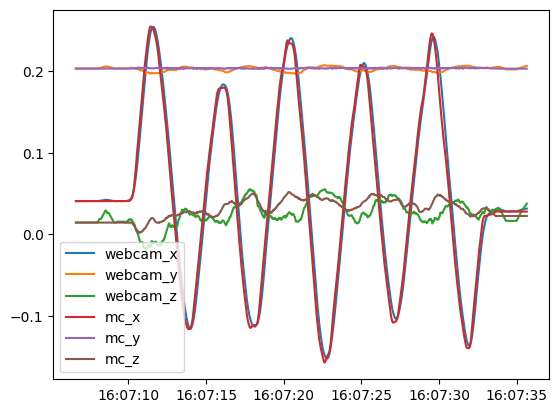

In [ ]:
# plot _w_df and _mc_df
w_df = _w_df.copy(deep=True)

w_df.x = savgol_filter(_w_df.x, 51, 1)
w_df.y = savgol_filter(_w_df.y, 51, 1)
w_df.z = savgol_filter(_w_df.z, 51, 1)
plt.plot(_w_df.time, w_df.x, label="webcam_x")
plt.plot(_w_df.time, w_df.y, label="webcam_y")
plt.plot(_w_df.time, w_df.z, label="webcam_z")
plt.plot(_mc_df.time, _mc_df.x, label="mc_x")
plt.plot(_mc_df.time, _mc_df.y, label="mc_y")
plt.plot(_mc_df.time, _mc_df.z, label="mc_z")


plt.legend()